# Experiments

> A _Pisces experiment_ is a combined specification of data sets, validation method(s), and model architectures to use.

Let's go through the example provied in `<pisces>/experiment_config/base_config.json`:
```json
{
  "data_config": {
    "data_directory": "./data_sets",
    "sets": ""
  },
  "validation": {
    "method": "LEAVE_ONE_OUT",
    "parameter": null
  },
  "models": [
    "LOGISTIC"
  ],
  "features": [
    "ACTIVITY"
  ]
}
```
Let's break this down, to give you a sense for the kinds of experiments Pisces can run and how to modify this to suit your own investigations.

* `"data_config"`: This is a dictionary that specifies the data sets to use. 
  * The `"data_directory": "./data_sets` specifies that the data sets are located in the `data_sets` directory, which is a subdirectory of the current working directory.
  * The `"sets": ""` key specifies the names of the data sets to use. Since this is an empty string, all data sets in the directory will be used. Otherwise, this would be a comma-separated list of data set names, which are folders inside the `"data_directory"` that have subdirectories matching `cleaned_*`.
* `"validation"`: This is a dictionary that specifies the validation method to use.  
  * The `"method"` key specifies the validation method to use. Here, we use `"LEAVE_ONE_OUT"`, which means that each data set will be used to train a model, and then the model will be tested on the same data set.
  * The `"parameter"` key specifies any parameters that the validation method requires. `"LEAVE_ONE_OUT"`, then the parameter is the name of the column to use for the leave-one-out validation.

In [1]:
#| default_exp evaluations

In [2]:
#| hide 
%load_ext autoreload
%autoreload 2

In [3]:
#| hide
from nbdev.showdoc import *


In [4]:
#| export

from enum import Enum
from typing import List

from enum import Enum, auto
from typing import Dict, List, Optional, Tuple, Union

from pathlib import Path

import numpy as np

## Data set discovery using Prefix Trees

Data sets are discovered based on being folders within the provided data set root directory which contain subdirectories that start with `cleaned_`.  

Once the data sets are discovered, we take the `cleaned_<feature>` subdirectories and use the `<feature>` as the feature name. 

Then we take the files within the `cleaned_<feature>` subdirectories and discover the ids that data set has for that feature. These do not need to be the same across features, hence all of our data getters might also return `None`.

Automagic ID discovery is done using a prefix tree, which is a data structure that allows for efficient searching of strings based on their prefixes.

In [5]:
#| export

from copy import deepcopy
import warnings

class SimplifiablePrefixTree:
    """A standard prefix tree with the ability to "simplify" itself by combining nodes with only one child.

    These also have the ability to "flatten" themselves, which means to convert all nodes at and below a certain depth into leaves on the most recent ancestor of that depth.

    Parameters
    ----------
    delimiter : str
        The delimiter to use when splitting words into characters. If empty, the words are treated as sequences of characters.
    key : str
        The key of the current node in its parent's `.children` dictionary. If empty, the node is (likely) the root of the tree.
    
    Attributes
    ----------
    key : str
        The key of the current node in its parent's `.children` dictionary. If empty, the node is (likely) the root of the tree.
    children : Dict[str, SimplifiablePrefixTree]
        The children of the current node, stored in a dictionary with the keys being the children's keys.
    is_end_of_word : bool
        Whether the current node is the end of a word. Basically, is this a leaf node?
    delimiter : str
        The delimiter to use when splitting words into characters. If empty, the words are treated as sequences of characters.
    print_spacer : str
        The string to use to indent the printed tree.
    
    Methods
    -------
    chars_from(word: str) -> List[str]
        Splits a word into characters, using the `delimiter` attribute as the delimiter.
    insert(word: str) -> None
        Inserts a word into the tree.
    search(word: str) -> bool
        Searches for a word in the tree.
    simplified() -> SimplifiablePrefixTree
        Returns a simplified copy of the tree. The original tree is not modified.
    simplify() -> SimplifiablePrefixTree
        Simplifies the tree in place.
    reversed() -> SimplifiablePrefixTree
        Returns a reversed copy of the tree, except with with `node.key` reversed versus the node in `self.children`. The original tree is not modified.
    flattened(max_depth: int = 1) -> SimplifiablePrefixTree
        Returns a Tree identical to `self` up to the given depth, but with all nodes at + below `max_depth` converted into leaves on the most recent acestor of lepth `max_depth - 1`.
    _pushdown() -> List[SimplifiablePrefixTree]
        Returns a list corresponding to the children of `self`, with `self.key` prefixed to each child's key.
    print_tree(indent=0) -> str
        Prints the tree, with indentation.
    """
    def __init__(self, delimiter: str = "", key: str = ""):
        self.key = key
        self.children: Dict[str, SimplifiablePrefixTree] = {}
        self.is_end_of_word = False
        self.delimiter = delimiter
        self.print_spacer = "++"
    
    def chars_from(self, word: str):
        return word.split(self.delimiter) if self.delimiter else word

    def insert(self, word: str):
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                node.children[char] = SimplifiablePrefixTree(self.delimiter, key=char)
            node = node.children[char]
        node.is_end_of_word = True

    def search(self, word: str) -> bool:
        node = self
        for char in self.chars_from(word):
            if char not in node.children:
                return False
            node = node.children[char]
        return node.is_end_of_word
    
    def simplified(self) -> 'SimplifiablePrefixTree':
        self_copy = deepcopy(self)
        return self_copy.simplify()
    
    def simplify(self):
        if len(self.children) == 1 and not self.is_end_of_word:
            child_key = list(self.children.keys())[0]
            self.key += child_key
            self.children = self.children[child_key].children
            self.simplify()
        else:
            current_keys = list(self.children.keys())
            for key in current_keys:
                child = self.children.pop(key)
                child.simplify()
                self.children[child.key] = child
        return self
    
    def reversed(self) -> 'SimplifiablePrefixTree':
        rev_self = SimplifiablePrefixTree(self.delimiter, key=self.key[::-1])
        rev_self.children = {k[::-1]: v.reversed() for k, v in self.children.items()}
        return rev_self
    
    def flattened(self, max_depth: int = 1) -> 'SimplifiablePrefixTree':
        """Returns a Tree identical to `self` up to the given depth, but with all nodes at + below `max_depth` converted into leaves on the most recent acestor of lepth `max_depth - 1`.
        """
        flat_self = SimplifiablePrefixTree(self.delimiter, key=self.key)
        if max_depth == 0:
            if not self.is_end_of_word:
                warnings.warn(f"max_depth is 0, but {self.key} is not a leaf.")
            return flat_self
        if max_depth == 1:
            for k, v in self.children.items():
                if v.is_end_of_word:
                    flat_self.children[k] = SimplifiablePrefixTree(self.delimiter, key=k)
                else:
                    # flattened_children = v._pushdown()
                    for flattened_child in v._pushdown():
                        flat_self.children[flattened_child.key] = flattened_child
        else:
            for k, v in self.children.items():
                flat_self.children[k] = v.flattened(max_depth - 1)
        return flat_self
    
    def _pushdown(self) -> List['SimplifiablePrefixTree']:
        """Returns a list corresponding to the children of `self`, with `self.key` prefixed to each child's key.
        """
        pushed_down = [
            c
            for k in self.children.values()
            for c in k._pushdown()
        ]
        for i in range(len(pushed_down)):
            pushed_down[i].key = self.key + self.delimiter + pushed_down[i].key

        if not pushed_down:
            return [SimplifiablePrefixTree(self.delimiter, key=self.key)]
        else:
            return pushed_down
            

    def __str__(self):
        # prints .children recursively with indentation
        return self.key + "\n" + self.print_tree()

    def print_tree(self, indent=0) -> str:
        result = ""
        for key, child in self.children.items():
            result +=  self.print_spacer * indent + "( " + child.key + "\n"
            result += SimplifiablePrefixTree.print_tree(child, indent + 1)
        return result


class IdExtractor(SimplifiablePrefixTree):
    """Class extending the prefix trees that incorporates the algorithm for extracting IDs from a list of file names. The algorithm is somewhat oblique, so it's better to just use the `extract_ids` method versus trying to use the prfix trees directly at the call site.
    
    The algorithm is based on the assumption that the IDs are the same across all file names, but that the file names may have different suffixes. The algorithm reverses the file names, inserts them into the tree, and then simplifes and flattens that tree in order to find the IDs as leaves of that simplified tree.

    1. Insert the file name string into the tree, but with each string **reversed**.
    2. Simplify the tree, combining nodes with only one child.
    3. There may be unexpected suffix matches for these IDs, so we flatten the tree to depth 1, meaning all children of the root are combined to make leaves.
    4. The leaves are the IDs we want to extract. However, we must reverse these leaf keys to get the original IDs, since we reversed the file names in step 1.

    TODO:
    * If we want to find IDs for files with differing prefixes instead, we should instead insert the file names NOT reversed and then NOT reverse in the last step.

    * To handle IDs that appear in the middle of file names, we can use both methods to come up with a list of potential IDs based on prefix and suffix, then figure out the "intersection" of those lists. (Maybe using another prefix tree?)

    """
    def __init__(self, delimiter: str = "", key: str = ""):
        super().__init__(delimiter, key)

    def extract_ids(self, files: List[str]) -> List[str]:
        for file in files:
            self.insert(file[::-1])
        return sorted([
            c.key for c in self
                .prefix_flattened()
                .children
                .values()
        ])
    
    def prefix_flattened(self) -> 'IdExtractor':
        return self.simplified().flattened(1).reversed()
    

In [6]:
#| test
entries = [
    '3XYZabc12',
    '3XY&abc12',
    '3XYAabc12',
    '3XYBabc12',
    'MMVQabc12',
    'NMVQabc12',
]

expected_ids = sorted([
    '3XYZ',
    '3XY&',
    '3XYA',
    '3XYB',
    'MMVQ',
    'NMVQ',
])

id_extractor = IdExtractor()

ids = id_extractor.extract_ids(entries)

# assert ids == expected_ids, f"Expected {expected_ids}, but got {ids}"
for i, (expected, actual) in enumerate(zip(expected_ids, ids)):
    assert expected == actual, f"Expected {expected}, but got {actual} at index {i}"


In [7]:
#| hide
print(id_extractor)


( 2
++( 1
++++( c
++++++( b
++++++++( a
++++++++++( Z
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( &
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( A
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( B
++++++++++++( Y
++++++++++++++( X
++++++++++++++++( 3
++++++++++( Q
++++++++++++( V
++++++++++++++( M
++++++++++++++++( M
++++++++++++++++( N



In [8]:
#| hide
print(id_extractor.prefix_flattened())

abc12
( 3XYZ
( 3XY&
( 3XYA
( 3XYB
( MMVQ
( NMVQ



In [9]:
#| export

import os
import re
import polars as pl
from typing import DefaultDict, Iterable
from collections import defaultdict
import logging

from pisces.utils import determine_header_rows_and_delimiter

LOG_LEVEL = logging.INFO

class DataSetObject:
    FEATURE_PREFIX = "cleaned_"

    # Set up logging
    logger = logging.getLogger(__name__)
    logger.setLevel(LOG_LEVEL)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler = logging.StreamHandler()
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    def __init__(self, name: str, path: Path):
        self.name = name
        self.path = path
        self.ids: List[str] = []

        # keeps track of the files for each feature and user
        self._feature_map: DefaultDict[str, Dict[str, str]] = defaultdict(dict)
        self._feature_cache: DefaultDict[str, Dict[str, pl.DataFrame]] = defaultdict(dict)
    
    @property
    def features(self) -> List[str]:
        return list(self._feature_map.keys())
    
    def __str__(self):
        return f"{self.name}: {self.path}"

    def get_feature_data(self, feature: str, id: str) -> pl.DataFrame | None:
        if feature not in self.features:
            warnings.warn(f"Feature {feature} not found in {self.name}. Returning None.")
            return None
        if id not in self.ids:
            warnings.warn(f"ID {id} not found in {self.name}")
            return None
        if (df := self._feature_cache[feature].get(id)) is None:
            file = self.get_filename(feature, id)
            if not file:
                return None
            self.logger.debug(f"Loading {file}")
            try:
                n_rows, delimiter = determine_header_rows_and_delimiter(file)
                # self.logger.debug(f"n_rows: {n_rows}, delimiter: {delimiter}")
                df = pl.read_csv(file, has_header=True if n_rows > 0 else False,
                                 skip_rows=max(n_rows-1, 0), 
                                 separator=delimiter)
            except Exception as e:
                warnings.warn(f"Error reading {file}:\n{e}")
                return None
            # sort by time when loading
            df.sort(df.columns[0])
            self._feature_cache[feature][id] = df
        return df

    def get_filename(self, feature: str, id: str) -> Path | None:
        feature_ids = self._feature_map.get(feature)
        if feature_ids is None:
            # raise ValueError(f"Feature {feature_ids} not found in {self.name}")
            print(f"Feature {feature_ids} not found in {self.name}")
            return None
        file = feature_ids.get(id)
        if file is None:
            # raise ValueError
            print(f"ID {id} not found in {self.name}")
            return None
        return self.get_feature_path(feature)\
            .joinpath(file)
    
    def get_feature_path(self, feature: str) -> Path:
        return self.path.joinpath(self.FEATURE_PREFIX + feature)
    
    def _extract_ids(self, files: List[str]) -> List[str]:
        return IdExtractor().extract_ids(files)
    
    def add_feature_files(self, feature: str, files: Iterable[str]):
        if feature not in self.features:
            self.logger.debug(f"Adding feature {feature} to {self.name}")
            self._feature_map[feature] = {}
        # use a set for automatic deduping
        deduped_ids = set(self.ids)
        extracted_ids = sorted(self._extract_ids(files))
        files = sorted(list(files))
        # print('# extracted_ids:', len(extracted_ids))
        for id, file in zip(extracted_ids, files):
            # print('adding data for id:', id, 'file:', file)
            self._feature_map[feature][id] = file
            # set.add only adds the value if it's not already in the set
            deduped_ids.add(id)
        self.ids = sorted(list(deduped_ids))
    
    def get_feature_files(self, feature: str) -> Dict[str, str]:
        return {k: v for k, v in self._feature_map[feature].items()}
    
    def get_id_files(self, id: str) -> Dict[str, str]:
        return {k: v[id] for k, v in self._feature_map.items()}
    
    def load_feature_data(self, feature: str | None, id: str | None) -> Dict[str, np.ndarray]:
        if feature not in self.features:
            raise ValueError(f"Feature {feature} not found in {self.name}")
    
    @classmethod
    def find_data_sets(cls, root: str | Path) -> Dict[str, 'DataSetObject']:
        set_dir_regex = r".*" + cls.FEATURE_PREFIX + r"(.+)"
        # this regex matches the feature directory name and the data set name
        # but doesn't work on Windows (? maybe, cant test) because of the forward slashes
        feature_dir_regex = r".*/(.+)/" + cls.FEATURE_PREFIX + r"(.+)"

        data_sets: Dict[str, DataSetObject] = {}
        for root, dirs, files in os.walk(root, followlinks=True):
            # check to see if the root is a feature directory,
            # if it is, add that feature data to the data set object,
            # creating a new data set object if necessary.
            if (root_match := re.match(feature_dir_regex, root)):
                cls.logger.debug(f"Feature directory: {root}")
                cls.logger.debug(f"data set name: {root_match.group(1)}")
                cls.logger.debug(f"feature is: {root_match.group(2)}", )
                data_set_name = root_match.group(1)
                feature_name = root_match.group(2)
                if (data_set := data_sets.get(data_set_name)) is None:
                    data_set = DataSetObject(root_match.group(1), Path(root).parent)
                    data_sets[data_set.name] = data_set
                files = [f for f in files if not f.startswith(".") and not f.endswith(".tmp")]
                data_set.add_feature_files(feature_name, files)
        
        return data_sets
    



## Model preprocessing

In [10]:
#| export
from numpy.lib.stride_tricks import as_strided

def psg_to_sleep_wake(psg: pl.DataFrame) -> np.array:
    # map all positive classes to 1 (sleep)
    # retain all 0 (wake) and -1 (mask) classes
    return np.where(psg[:, 1] > 0, 1, psg[:, 1])

def get_activity_X_PSG_y(data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
    activity_0 = data_set.get_feature_data("activity", id)
    psg_0 = data_set.get_feature_data("psg", id)

    if activity_0 is None or psg_0 is None:
        return None

    # trim the activity and psg data to both end when the 0th column (time) of either ends
    end_time = min(activity_0[-1, 0], psg_0[-1, 0])
    rows_retained = sum(activity_0[:, 0] <= end_time)
    activity_0 = activity_0.filter(activity_0[:, 0] <= end_time)
    psg_0 = psg_0.filter(psg_0[:, 0] <= end_time)

    X = activity_0[:, 1].to_numpy()
    # make the reshape(-1, 2) non-ragged 
    # remove the last element if the length is odd
    if res := X.shape[0] % 2:
        #! X[:-0] is empty, so don't do this if res == 0
        X = X[:-res] 
    X = X.reshape((-1, 2)).sum(axis=1)
    y = psg_to_sleep_wake(psg_0)

    return X, y

def rolling_window(arr, window_size):
    strided_axis_0 = max(arr.shape[0] - window_size + 1, 0)
    arr_strided = as_strided(arr, shape=(strided_axis_0, window_size), strides=(arr.strides[0], arr.strides[0]))
    return arr_strided

In [11]:
#| test
input_vec = np.arange(10)
expected_rolling = np.array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])
rolled = rolling_window(input_vec, 3)

assert np.array_equal(rolled, expected_rolling), f"Expected {expected_rolling}, but got {rolled}"

## Classifier models

In [12]:
#| export
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
import numpy as np

from pisces.enums import KnownModel


class SleepWakeClassifier:
    @property
    def model_type(self) -> KnownModel:
        raise NotImplementedError
    @classmethod
    def get_needed_X_y(cls, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        raise NotImplementedError
    def train(self, examples_X: List[pl.DataFrame] = [], examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        raise NotImplementedError
    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        raise NotImplementedError
    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        raise NotImplementedError
    def roc_curve(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError
    def roc_auc(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> float:
        raise NotImplementedError

class SGDLogisticRegression(SleepWakeClassifier):
    """Eventually, will be the base class. But for now, it will be the only example and it's logistic regression.

    That is, this has a matrix A of shape (n_examples, n_features) and a 'bias' vector b of shape (n_examples, 1).

    This model then learns A and b to optimize model.predict(x) = sigmoid(A @ x + b), where x is the input.
    
    """
    def __init__(self, lr: float = 0.15, input_dim: int = 11, output_dim: int = 1):
        self.model = SGDClassifier(loss='log_loss',
                                   learning_rate='adaptive',
                                   penalty='l1',
                                   eta0=lr,
                                   class_weight='balanced',
                                   warm_start=True)
        self.scaler = StandardScaler()
        self.pipeline = make_pipeline(self.scaler, self.model)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.window_step = 1

    @classmethod
    def get_needed_X_y(cls, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        return get_activity_X_PSG_y(data_set, id)
    
    @property
    def model_type(self) -> KnownModel:
        return KnownModel.LOG_REG_SKLEARN

    def _prepare_labels(self, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        y_trimmed = self._trim_labels(y)
        n_sleep = np.sum(y_trimmed > 0)
        n_wake = np.sum(y_trimmed == 0)
        N = n_sleep + n_wake
        # Want to make a balanced weight loss, along with giving 0.0 * loss for masked values (y < 0)
        mask_weights_zero = np.where(y_trimmed < 0, 1.0, 1)
        # balancing_weights_ignore_mask = np.where(y_trimmed > 0, n_wake / N, n_sleep / N)
        balancing_weights_ignore_mask = np.where(y_trimmed > 0, N / n_sleep, N / n_wake)
        sample_weights = mask_weights_zero * balancing_weights_ignore_mask

        y_demasked = np.where(y_trimmed < 0, 0, y_trimmed)

        return y_demasked, sample_weights

    def train(self, examples_X: List[pl.DataFrame] = [], examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        if examples_X or examples_y:
            assert len(examples_X) == len(examples_y)
        if pairs_Xy:
            assert not examples_X
        
        training = []
        training_iterator = iter(pairs_Xy) if pairs_Xy else zip(examples_X, examples_y)
        for X, y in training_iterator:
            try:
                X_folded = self._fold(X)
                y_prepped, sample_weights = self._prepare_labels(y)
                if (X_folded.shape[0] != y_prepped.shape[0]) \
                    or (X_folded.shape[0] == 0) \
                    or (y_prepped.shape[0] == 0):
                    continue
                training.append((X_folded, y_prepped, sample_weights))
            except Exception as e:
                print(f"Error folding or trimming data: {e}")
                continue
        
        Xs = [X for X, _, _ in training]
        ys = [y for _, y, _ in training]
        weights = [w for _, _, w in training]
        Xs = np.concatenate(Xs, axis=0)
        ys = np.concatenate(ys, axis=0)
        weights = np.concatenate(weights, axis=0)

        selector = ys >= 0
        Xs = Xs[selector]
        ys = ys[selector]
        weights = weights[selector]

        self.pipeline.fit(Xs, ys)
    
    def _input_preprocessing(self, X: np.ndarray) -> np.ndarray:
        return self.scaler.transform(self._fold(X))
    
    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict(self._input_preprocessing(sample_X))
    
    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return self.model.predict_proba(self._input_preprocessing(sample_X))

    def roc_auc(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> float:
        prediction, labels, balancing_weights = self._evaluation_preprocessing(examples_X_y)
        auc = roc_auc_score(labels, prediction)
        return auc
    
    def _evaluation_preprocessing(self, examples_X_y: Tuple[np.ndarray, np.ndarray]
                                  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        labels, balancing_weights = self._prepare_labels(examples_X_y[1])

        # get probability of sleep
        prediction = self.predict_probabilities(examples_X_y[0])[:, -1]
        # drop all -1 (mask) classes
        min_matching_length = min(len(labels), len(prediction))
        prediction = prediction[:min_matching_length]
        if len(prediction) != len(labels):
            print(f"prediction: {prediction.shape}, labels: {labels.shape}")
        labels = labels[:min_matching_length]
        balancing_weights = balancing_weights[:min_matching_length]

        return prediction, labels, balancing_weights

    def roc_curve(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        prediction, labels, balancing_weights = self._evaluation_preprocessing(examples_X_y)
        fpr, tpr, _ = roc_curve(labels, prediction, sample_weight=balancing_weights)
        return fpr, tpr


    def _fold(self, input_X: np.ndarray | pl.DataFrame) -> np.array:
        if isinstance(input_X, pl.DataFrame):
            xa = input_X.to_numpy()
        return rolling_window(input_X, self.input_dim)
    
    def _trim_labels(self, labels_y: pl.DataFrame) -> np.ndarray:
        start, end = self._indices_to_trim()
        # return labels_y[self.input_dim:]
        return labels_y[start:-end]
        
    def _indices_to_trim(self) -> Tuple[int, int]:
        # ex: input_dim = 8 => (4, 3)
        # ex: input_dim = 7 => (3, 3)
        # ex: input_dim = 6 => (3, 2)
        return (self.input_dim // 2, self.input_dim - (self.input_dim // 2))


### Mads Olsen et all classifier

We have downloaded the saved model weights from a paper by Mads Olsen's group. Thus, we have a TensorFlow Lite model that we can run inference on, and we could train it if we wanted to (I think?).

For simplicity, we are just going to run inference. One twist of our method is that the classifier is expecting two high-resolution spectrograms for inputs:
1. 3-axis Accelerometer data
2. PPG (photoplethysmogram) data
Based on visually inspecting examples from the paper, we are going to hack together an input by flipping the accelerometer data along the frequencies axis. The paper images seem to show a similarity between high-frequency accelerometer data and low-frequency PPG data. Surprisingly, this seems to work well.

In [13]:
#| export
import os
import sys
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import spectrogram
from scipy.stats import zscore

from functools import partial

import pandas as pd
from pisces.enums import KnownModel
import tensorflow as tf
import pkg_resources

FS = 32
CHANNELS = 1
DEPTH = 9
N_OUT = 2 ** (DEPTH + 1)
N_CLASSES = 4

MO_UNET_CONFIG = {
    "input_shape": (15360, 32, CHANNELS),
    "num_classes": N_CLASSES,
    "num_outputs": N_OUT,
    "init_filter_num": 8,  # 16,
    "filter_increment_factor": 2 ** (1 / 3),
    "max_pool_size": (2, 2),
    "depth": DEPTH,
    "kernel_size": (16, 3),
}

MO_PREPROCESSING_CONFIG = {
    "preprocessing": [
        {"args": {"window_size": 30, "fs": FS}, "type": "median"},
        {
            "args": {"iqr_window": 300, "median_window": 300, "fs": FS},
            "type": "iqr_normalization_adaptive",
        },
        {"args": {"threshold": 20, "fs": FS}, "type": "clip_by_iqr"},
        {
            "args": {
                "fs": FS,
                "nfft": 512,
                "f_max": 6,
                "f_min": 0,
                "f_sub": 3,
                "window": 320,
                "noverlap": 256,
            },
            "type": "cal_psd",
        },
    ]
}

def median(x, fs, window_size):
    if isinstance(x, pl.DataFrame):
        x = x.to_numpy()

    window = (
        (fs * window_size + 1) if (fs * window_size) % 2 == 0 else (fs * window_size)
    )

    reduce_dims = False
    if len(x.shape) == 1:
        x = np.expand_dims(x, axis=-1)
        reduce_dims = True
    x_norm = np.zeros((x.shape))

    for idx in range(x.shape[-1]):

        x_med = np.ones((x.shape[0])) * np.median(x[:, idx])

        x_pd = pd.Series(x[:, idx])
        med_ = x_pd.rolling(window).median()
        x_med[int(window / 2) : -int(window / 2)] = med_[window - 1 :]
        x_med[: int(window / 2)] = med_[window - 1]
        x_med[-int(window / 2) :] = med_[-1:]

        x_med[np.isnan(x_med)] = 0  # remove nan

        x_norm[:, idx] = x[:, idx] - x_med

    if reduce_dims:
        x_norm = x_norm[:, 0]
    return x_norm


def clip_by_iqr(x, fs, threshold=20):

    x[x > threshold] = threshold
    x[x < -threshold] = -threshold

    return x

def iqr_normalization_adaptive(x, fs, median_window, iqr_window):
    def normalize(x, fs, median_window, iqr_window, iqr_upper=0.75, iqr_lower=0.25):

        # add noise
        x_ = x + np.random.normal(loc=0, scale=sys.float_info.epsilon, size=(x.shape))

        # fix window parameters to odd number
        med_window = (
            (fs * median_window + 1)
            if (fs * median_window) % 2 == 0
            else (fs * median_window)
        )
        iqr_window = (
            (fs * iqr_window + 1) if (fs * iqr_window) % 2 == 0 else (fs * iqr_window)
        )

        # preallocation
        x_med = np.ones((x.shape)) * np.median(x_)
        x_iqr_up = np.ones((x.shape)) * np.quantile(x_, iqr_upper)
        x_iqr_lo = np.ones((x.shape)) * np.quantile(x_, iqr_lower)

        # find rolling median
        x_pd = pd.Series(x_)
        med_ = x_pd.rolling(med_window).median()
        x_med[int(med_window / 2) : -int(med_window / 2)] = med_[med_window - 1 :]
        x_med[np.isnan(x_med)] = 0  # remove nan

        # find rolling quantiles
        x_iqr_upper = x_pd.rolling(iqr_window).quantile(iqr_upper)
        x_iqr_lower = x_pd.rolling(iqr_window).quantile(iqr_lower)

        # border padding
        x_iqr_up[int(iqr_window / 2) : -int(iqr_window / 2)] = x_iqr_upper[
            iqr_window - 1 :
        ]
        x_iqr_lo[int(iqr_window / 2) : -int(iqr_window / 2)] = x_iqr_lower[
            iqr_window - 1 :
        ]

        # remove nan
        x_iqr_up[np.isnan(x_iqr_up)] = 0
        x_iqr_lo[np.isnan(x_iqr_lo)] = 0

        # return normalize
        return (x_ - x_iqr_lo) / (x_iqr_up - x_iqr_lo + sys.float_info.epsilon) * 2 - 1

    x_norm = np.zeros((x.shape))
    if len(x.shape) == 1:
        x_norm[:] = normalize(x, fs, median_window, iqr_window)
    else:
        for n in range(x.shape[1]):
            x_norm[:, n] = normalize(x[:, n], fs, median_window, iqr_window)
    return x_norm


from scipy.signal import spectrogram

def cal_psd(x, fs, window, noverlap, nfft, f_min, f_max, f_sub=1):
    """
    https://github.com/MADSOLSEN/SleepStagePrediction/blob/d47ff488f5cedd3b0459593a53fc4f92fc3660a2/signal_processing/spectrogram.py#L91
    """
    from scipy.ndimage import maximum_filter as maxfilt

    # border edit
    x_ = np.zeros((x.size + window,))
    x_[window // 2 : -window // 2] = x
    x_ = x_ + np.random.normal(loc=0, scale=sys.float_info.epsilon, size=(x_.shape))

    f, t, S = spectrogram(
        x=x_,
        fs=fs,
        window=np.blackman(window),
        nperseg=window,
        noverlap=noverlap,
        nfft=nfft,
    )

    S = S[(f > f_min) & (f <= f_max), :]
    S = maxfilt(np.abs(S), size=(f_sub, 1))
    S = S[::f_sub, :]
    S = np.swapaxes(S, axis1=1, axis2=0)
    S = np.log(S + sys.float_info.epsilon)
    if S.shape[1] != 24:
        k = 1

    assert np.sum(np.isinf(S)) == 0
    assert np.sum(np.isnan(S)) == 0
    return S

def _load_from_tflite() -> tf.lite.Interpreter:
    file_path = pkg_resources.resource_filename('pisces', 'cached_models/mo_resunet.tflite')
    tflite_model = tf.lite.Interpreter(model_path=file_path)
    tflite_model.allocate_tensors()

    return tflite_model


class MOResUNetPretrained(SleepWakeClassifier):
    tflite_model = _load_from_tflite()
    config = MO_PREPROCESSING_CONFIG

    def __init__(
        self,
    ) -> None:
        super().__init__()
    
    @classmethod
    def get_needed_X_y(cls, data_set: DataSetObject, id: str) -> Tuple[np.ndarray, np.ndarray] | None:
        accelerometer = data_set.get_feature_data("accelerometer", id)
        psg = data_set.get_feature_data("psg", id)

        if accelerometer is None or psg is None:
            return None
        
        stop_time = min(accelerometer[-1, 0], psg[-1, 0])
        accelerometer = accelerometer.filter(accelerometer[:, 0] <= stop_time)
        psg = psg.filter(psg[:, 0] <= stop_time)

        mirrored_spectro = cls._input_preprocessing(accelerometer)

        return mirrored_spectro, psg_to_sleep_wake(psg)

    def train(self, 
              examples_X: List[pl.DataFrame] = [], 
              examples_y: List[pl.DataFrame] = [], 
              pairs_Xy: List[Tuple[pl.DataFrame, pl.DataFrame]] = [], 
              epochs: int = 10, batch_size: int = 32):
        """This function does nothing, because this is a pre-trained, non-trainable model."""
        pass

    def predict(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        return np.argmax(self.predict_probabilities(sample_X), axis=1)

    def predict_probabilities(self, sample_X: np.ndarray | pl.DataFrame) -> np.ndarray:
        if isinstance(sample_X, pl.DataFrame):
            sample_X = sample_X.to_numpy()
        return self.eval_tflite_interp(sample_X)

    def roc_curve(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError
    def roc_auc(self, examples_X_y: Tuple[np.ndarray, np.ndarray]) -> float:
        raise NotImplementedError

    @property
    def model_type(self) -> KnownModel:
        return 

    @staticmethod

    def __setstate__(self, d):
        self.__dict__ = d
        self.tflite_model = self._load_from_tflite()

    # Called when pickling
    def __getstate__(self) -> dict:
        selfCopy = self
        selfCopy.tflite_model = None

        return selfCopy.__dict__

    @classmethod
    def _spectrogram_preprocessing(cls, acc_xyz: np.ndarray) -> np.ndarray:
        return cls._preprocessing(acc_xyz)

    @classmethod
    def _input_preprocessing(
        cls,
        acc_xyz: pl.DataFrame | np.ndarray
    ) -> np.ndarray:

        spec = cls._spectrogram_preprocessing(acc_xyz)

        input_dets = cls.tflite_model.get_input_details()

        # We will copy the spectrogram to both channels, flipping it on channel 1
        input_shape = input_dets[0]["shape"]
        inputs_len = input_shape[1]

        inputs = np.zeros(shape=input_shape, dtype=np.float32)
        # We must do some careful work with indices to not overflow arrays
        spec = spec[:inputs_len].astype(np.float32) # protect agains spec.len > input_shape

        #! careful, order matters here. We first trim spec to make sure it'll fit into inputs,
        # then compute the new length which we KNOW is <= inputs_len
        spec_len = spec.shape[0]
        # THEN we assign only as much inputs as spec covers
        inputs[0, : spec_len, :, 0] = spec # protect agains spec_len < input_shape
        inputs[0, : spec_len, :, 1] = spec[:, ::-1]

        return inputs

    def eval_tflite_interp(self, inputs: np.ndarray) -> np.ndarray:
        # Boilerplate to run inference on a TensorFlow Lite model interpreter.
        input_dets = self.tflite_model.get_input_details()
        output_dets = self.tflite_model.get_output_details()

        self.tflite_model.set_tensor(input_dets[0]["index"], inputs)

        self.tflite_model.invoke()

        preds = self.tflite_model.get_tensor(output_dets[0]["index"])

        return preds
    
    @classmethod
    def _preprocessing(
        cls,
        acc: pl.DataFrame | np.ndarray
    ) -> np.ndarray:
        """
        The Mads Olsen repo uses a list of transformations
        """
        if isinstance(acc, pl.DataFrame):
            acc = acc.to_numpy()
        x_ = acc[:, 0]
        y_ = acc[:, 1]
        z_ = acc[:, 2]
        for step in cls.config["preprocessing"]:
            print(step)
            fn = eval(step["type"])  # convert string version to function in environment
            print(fn)
            fn_args = partial(
                fn, **step["args"]
            )  # fill in the args given, which must be everything besides numerical input

            # apply
            x_ = fn_args(x_)
            y_ = fn_args(y_)
            z_ = fn_args(z_)

        spec = x_ + y_ + z_
        spec /= 3.0

        return spec



INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
INFO: Failed to apply the default TensorFlow Lite delegate indexed at 0 because of incompatibility between runtime and delegate. Ignoring the error, and continuing anyway.


In [14]:
sets = DataSetObject.find_data_sets("../data_sets")
import matplotlib.pyplot as plt
w = sets['walch_et_al']
i = w.ids[0]
# mo_preprocessed_data = MOResUNetPretrained.get_needed_X_y(w, i)

In [15]:
acc_data = w.get_feature_data("accelerometer", i)[:, 1:]
print(acc_data.shape)

(1187903, 3)


### Training example

In [16]:
#| export
from typing import Type
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut

def run_split(train_indices, 
              preprocessed_data_set: List[Tuple[np.ndarray, np.ndarray]], 
              epochs: int, 
              swc: SleepWakeClassifier) -> SleepWakeClassifier:
    training_pairs = [
        preprocessed_data_set[i]
        for i in train_indices
        if preprocessed_data_set[i]
    ]
    swc.train(pairs_Xy=training_pairs, epochs=epochs)

    return swc

class SplitMaker:
    def split(self, ids: List[str]) -> Tuple[List[int], List[int]]:
        raise NotImplementedError
    
class LeaveOneOutSplitter(SplitMaker):
    def split(self, ids: List[str]) -> Tuple[List[int], List[int]]:
        loo = LeaveOneOut()
        return loo.split(ids)

def run_splits(split_maker: SplitMaker, w: DataSetObject, epochs: int, swc_class: Type[SleepWakeClassifier]) -> Tuple[
        List[SleepWakeClassifier], 
        List[np.ndarray],
        List[List[List[int]]]]:
    split_models: List[SGDLogisticRegression] = []
    test_indices = []
    splits = []

    preprocessed_data = [swc_class.get_needed_X_y(w, i) for i in w.ids]

    for train_index, test_index in tqdm(split_maker.split(w.ids)):
        if preprocessed_data[test_index[0]] is None:
            continue
        model = run_split(train_indices=train_index,
                        preprocessed_data_set=preprocessed_data,
                        epochs=500, swc=swc_class())
        split_models.append(model)
        test_indices.append(test_index[0])
        splits.append([train_index, test_index])
        # break
    
    return split_models, preprocessed_data, splits



In [17]:
loo = LeaveOneOutSplitter()

split_models, preprocessed_data, splits = run_splits(loo, sets['walch_et_al'], 500, SGDLogisticRegression)

31it [00:03,  7.91it/s]


### ROC AUC histograms

In [18]:
#| export
from pisces.loader import avg_steps
from sklearn.metrics import auc as auc_score

def add_rocs(ax, fprs: List[np.ndarray], tprs: List[np.ndarray], x_class: str = "SLEEP", y_class: str = "WAKE", min_auc: float = 0.0):
    
    aucs = np.array([
        auc_score(fpr, tpr)
        for fpr, tpr in zip(fprs, tprs)
    ])

    all_fprs, avg_curve = avg_steps(
            xs=[list(fprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
            ys=[list(tprs[i]) for i in range(len(aucs)) if aucs[i] > min_auc],
        )

    avg_auc = np.mean(aucs[aucs > min_auc])

    ax.step(
        all_fprs,
        avg_curve,
        c="tab:blue",
        where="post",
        label=f"All splits avg ROC-AUC: {avg_auc:0.3f}",
    )
    for roc in zip(fprs, tprs):
        ax.step(roc[0], roc[1], "tab:orange", alpha=0.2, where="post")
    ax.plot([0, 1], [0, 1], "-.", c="black")

    ax.set_ylabel(f"Fraction of {y_class} scored as {y_class}")
    ax.set_xlabel(f"Fraction of {x_class} scored as {y_class}")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

prediction: (914,), labels: (956,)


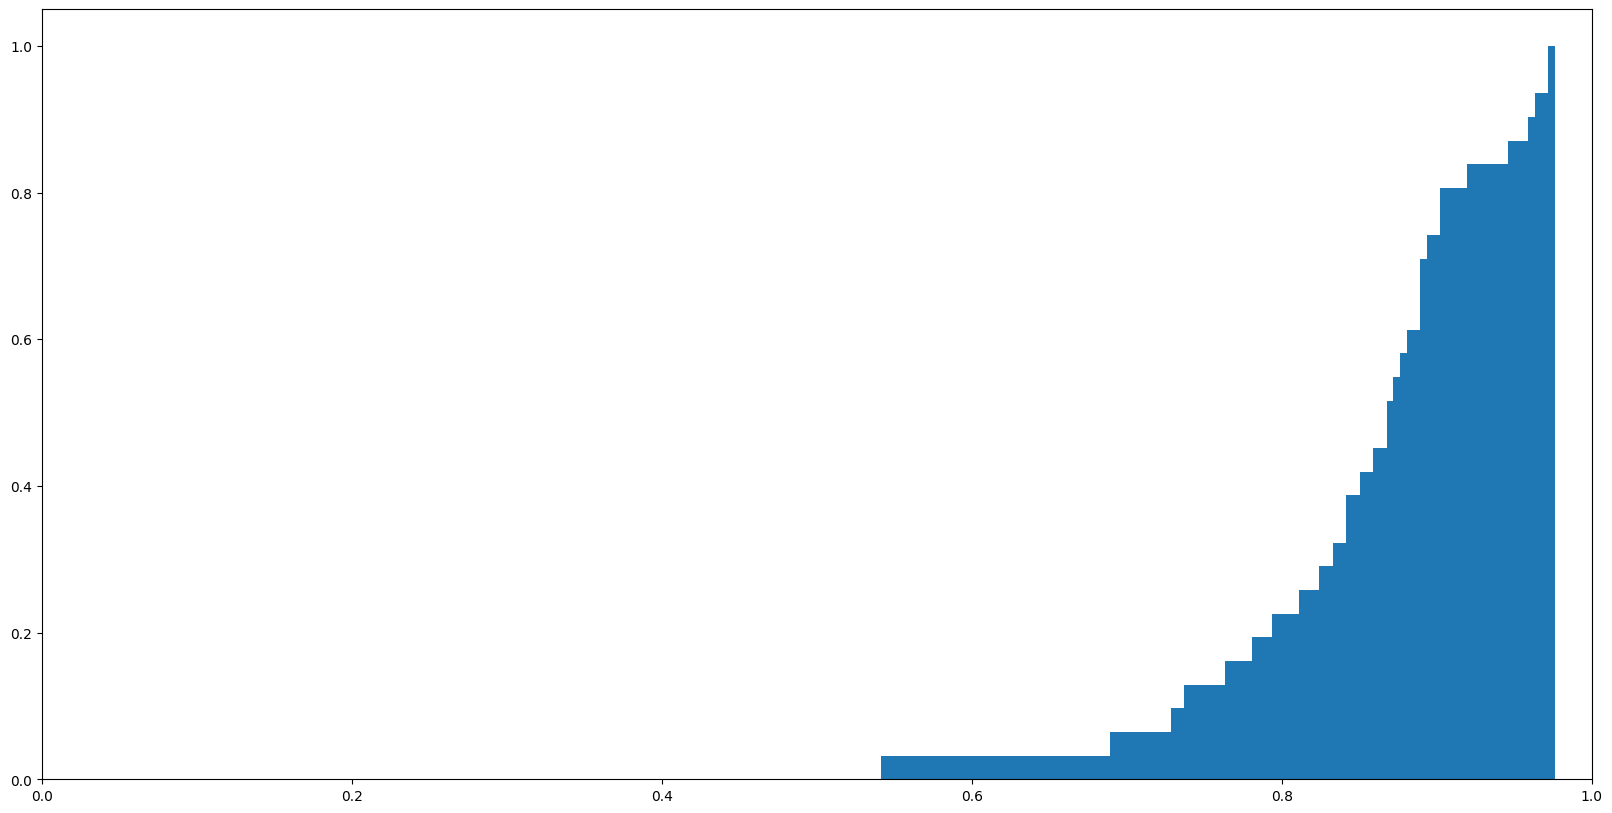

In [19]:
import matplotlib.pyplot as plt

SPLIT_NUMBER = 0

aucs = [
    split_models[i].roc_auc(
        preprocessed_data[
            splits[i][1][0]])
    for i in range(len(split_models))
]
plt.figure(figsize=(20, 10))
plt.xlim(0, 1)
_ = plt.hist(aucs,
             cumulative=True,
             density=True,
             bins=100)

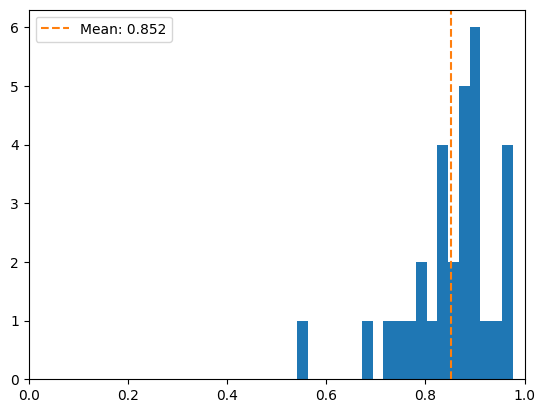

In [20]:
# plt.ylim(0, 1)
plt.xlim(0, 1)
plt.hist(aucs, bins=20)

# plot the mean as a vertical 'tab:orange' line
plt.axvline(np.mean(aucs), color='tab:orange', linestyle='--', label=f"Mean: {np.mean(aucs):.3f}")
plt.legend()

prediction: (914,), labels: (956,)


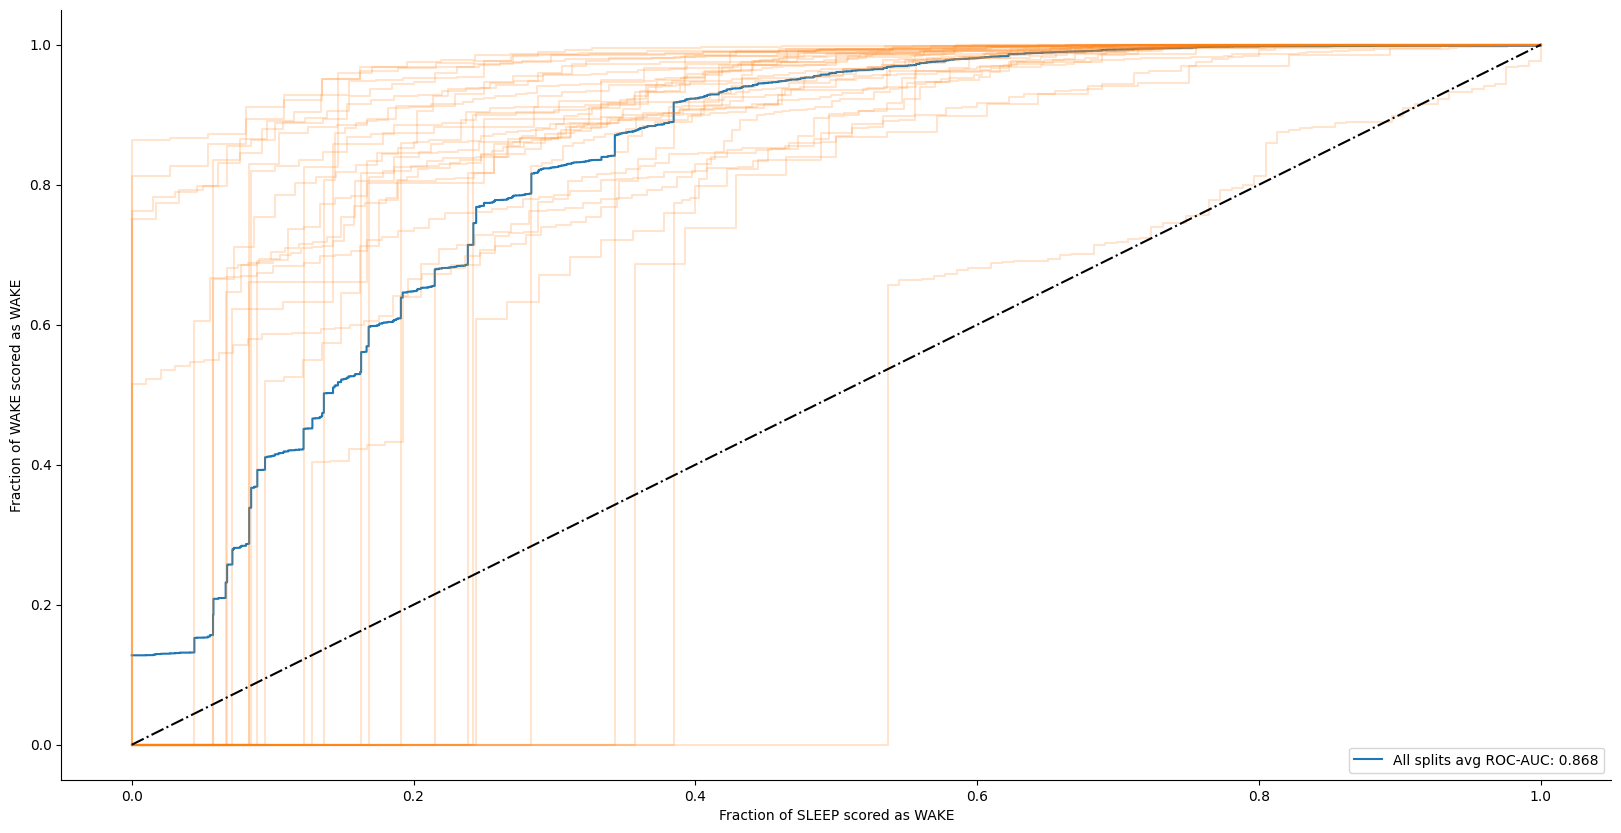

In [21]:
roc_curves = [
    split_models[i].roc_curve(
        preprocessed_data[
            splits[i][1][0]])
    for i in range(len(split_models))
]
fig, ax = plt.subplots(figsize=(20, 10))
add_rocs(
    ax, 
    [fpr for fpr, _ in roc_curves], 
    [tpr for _, tpr in roc_curves],
    min_auc=0.7)
ax.legend(loc='lower right')

### MO evaluation

{'args': {'window_size': 30, 'fs': 32}, 'type': 'median'}
<function median at 0x119643250>
{'args': {'iqr_window': 300, 'median_window': 300, 'fs': 32}, 'type': 'iqr_normalization_adaptive'}
<function iqr_normalization_adaptive at 0x177ecec20>
{'args': {'threshold': 20, 'fs': 32}, 'type': 'clip_by_iqr'}
<function clip_by_iqr at 0x177eceb90>
{'args': {'fs': 32, 'nfft': 512, 'f_max': 6, 'f_min': 0, 'f_sub': 3, 'window': 320, 'noverlap': 256}, 'type': 'cal_psd'}
<function cal_psd at 0x177ececb0>
X.shape = (1, 15360, 32, 2)


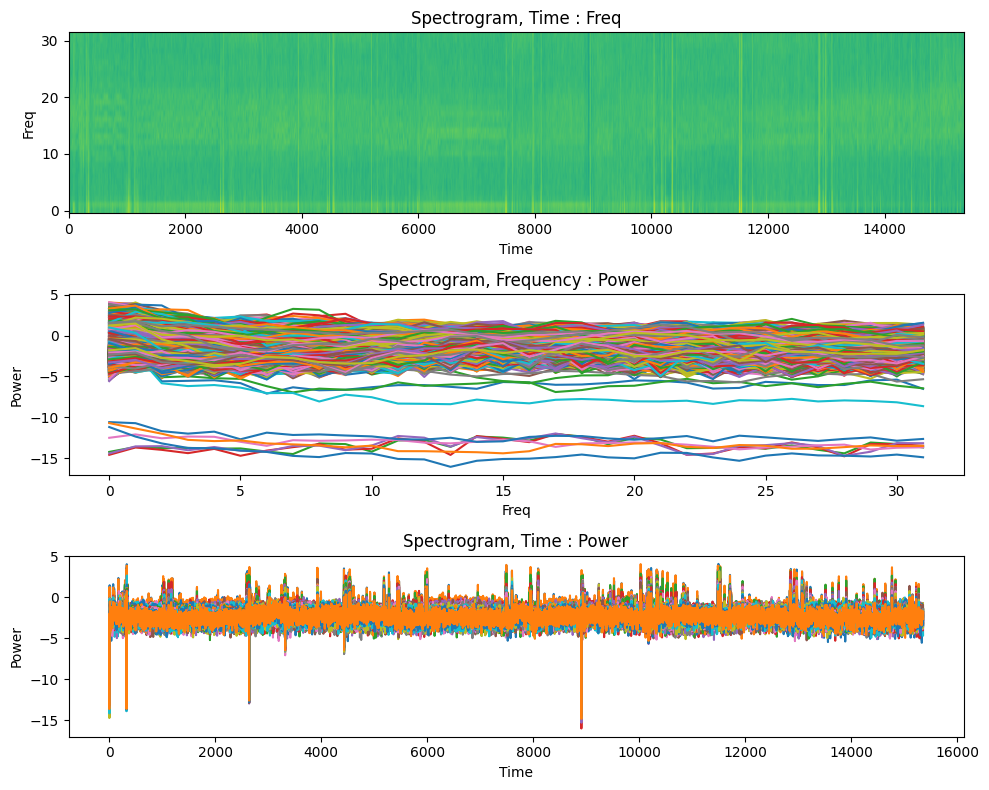

In [22]:
w = sets['walch_et_al']
subj = w.ids[0]
X, y = MOResUNetPretrained.get_needed_X_y(w, subj)
print("X.shape =", X.shape)
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# ax1.imshow(.T)
spec = X[0, 1:, :, 0].T
ax1.imshow(spec, origin="lower", aspect="auto")#, vmin=vmin, vmax=vmax)
ax1.set_title('Spectrogram, Time : Freq')
ax1.set_xlabel('Time')
ax1.set_ylabel('Freq')

ax2.plot(spec)
ax2.set_title('Spectrogram, Frequency : Power ')
ax2.set_xlabel('Freq')
ax2.set_ylabel('Power')
ax3.plot(spec.T)
ax3.set_title('Spectrogram, Time : Power')
ax3.set_xlabel('Time')
ax3.set_ylabel('Power')

plt.tight_layout()
plt.show()


In [23]:
mo = MOResUNetPretrained()


In [24]:
y_hat_proba = mo.predict_probabilities(X)

In [25]:
y_hat_proba.shape

(1, 1024, 4)

In [26]:
y.shape

(947,)

In [34]:
from pisces.utils import pad_to_hat


y_hat = np.argmax(y_hat_proba, axis=-1).reshape(-1)
y_hat.shape
y_padded = pad_to_hat(y, y_hat)
mask = pad_to_hat(np.ones(y.shape), y_hat)
plt.plot(mask, label='MASK')
# plt.plot(y_hat, label='Predicted')
# plt.plot(y_padded, label='True')
roc_auc_score(y_padded, y_hat, sample_weight=mask)

[autoreload of pisces.loader failed: Traceback (most recent call last):
  File "/Users/ericcanton/mambaforge/envs/pisces/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ericcanton/mambaforge/envs/pisces/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/ericcanton/mambaforge/envs/pisces/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/ericcanton/Engineering/Work/pisces/pisces/loader.py", line 12, in <module>
    class ValidationConfiguration:
  File "/Users/ericcanton/Engineering/Work/pisces/pisces/loader.py", line 14, in ValidationConfiguration


ImportError: cannot import name 'pad_to_hat' from 'pisces.utils' (/Users/ericcanton/Engineering/Work/pisces/pisces/utils.py)